# Project specification


## 1) Calibration (camera matrix, distortion coefficients)

## Pipeline
* 2) Color transform, Gradients -> thresholded binary image
* 3) Perspective transform
* 4) Identification of lane line pixels
* 5) Radius of curvature calculation
* 6) Lane area plotted back down onto the road

* (7) Lane history + smoothing)

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from help_func import draw_lines_from_points, show_img, show_imgs, create_comb_img
import pickle
from collections import deque
# for interactive plots
# %matplotlib notebook
%matplotlib inline

# Camera calibration

Criteria:  
Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.

Camera calibration requires both object points (x,y,z) and image points (x,y) of the calibration patterns.  
Since the chessboard pattern is assumed to be fixed at the (x,y) plane at z=0, the object points for all 9x6 calibration images are (0,0,0), (1,0,0), ... (8,5,0).  
The image points are determinded by the cv2.findChessboardCorners(), which outputs the 2D-coordinates of all chessboard corners from the input image.  

The function cv2.calibrateCamera() computes the camera matrix and distortion coefficients by using object and image points. Since the use of more than 10 calibration images is recommended ([openCV documentation](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_calibration/py_calibration.html)), all of the provided 20 images are used. The respective object and image points of the images are simply appended and then passed to the calibration function. 

Distorted images can now be corrected by using the cv2.undistort() function, which takes the calibration matrix and distortion coefficients as input arguments. An example of an undistorted calibration image is provided below.

In [2]:
img = mpimg.imread('test_images/test1.jpg')
rows, cols, channels = img.shape

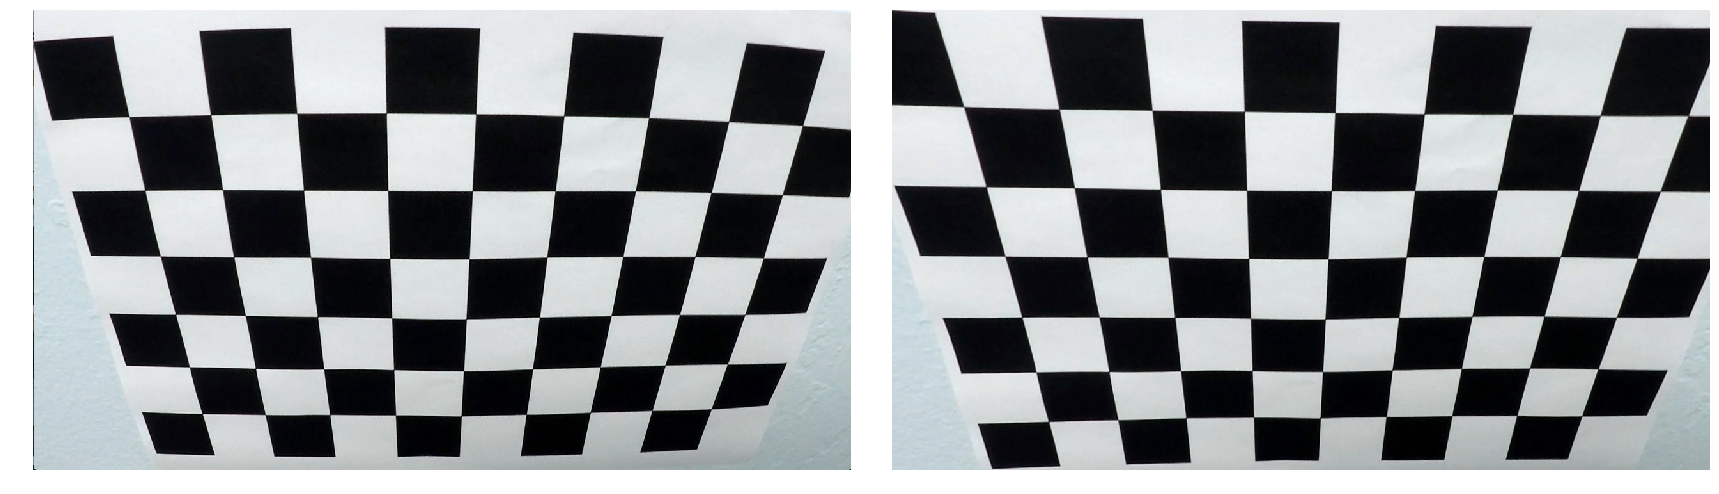

In [3]:
# initialize array for object points with dimensions (6*9, 3)
objp = np.zeros((6*9,3), np.float32)
# create mesh grid, transpose and reshape to get an (6*9, 2) array 
# for all object points (z component is assumed to be 0)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# initialize arrays for object- and image points from all calibration images
objpts = [] # 3D points in real world space
imgpts = [] # 2D points in image plane

# get list of all available calibration images
cal_images = glob.glob('camera_cal/calibration*.jpg')

# find chessboard corners in all images
for idx, img_name in enumerate(cal_images):
    img = cv2.imread(img_name) # read image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert to grayscale
    
    # find chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
    
    # if corners were found, object- and image points are added
    if ret == True:
        objpts.append(objp)
        imgpts.append(corners)

        # draw and display/save corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)        
        # folder_name = 'output_images/'
       # file_name = 'chessboard_corners_'+img_name[11:]
       # cv2.imwrite(folder_name+file_name, img)
#         plt.figure()
#         plt.imshow(img)
#         cv2.waitKey(500)

dist_img = cv2.imread('camera_cal/calibration2.jpg')

ret, mtx, dist_coeff, rvecs, tvecs = cv2.calibrateCamera(objpts, imgpts, (cols, rows), None ,None)

undist_img = cv2.undistort(dist_img, mtx, dist_coeff, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.axis('off'); ax1.imshow(dist_img);
ax2.axis('off'); ax2.imshow(undist_img);

# plt.imshow(undist_img)
# cv2.imwrite('output_images/calibration2_undistorted.jpg', undist)

# Pipeline (test images)

#### Criteria: Provide an example of a distortion-corrected image.

Now that the calibration matrix and distortion coefficients are available after the use of cv2.calibrateCamera(), every image taken with the same camera can be undistorted. The function cv2.undistort() is used for this task again. The results are shown below.

In [4]:
def undistort(dist_img):
    undist_img = cv2.undistort(dist_img, mtx, dist_coeff, None, mtx)
    return undist_img

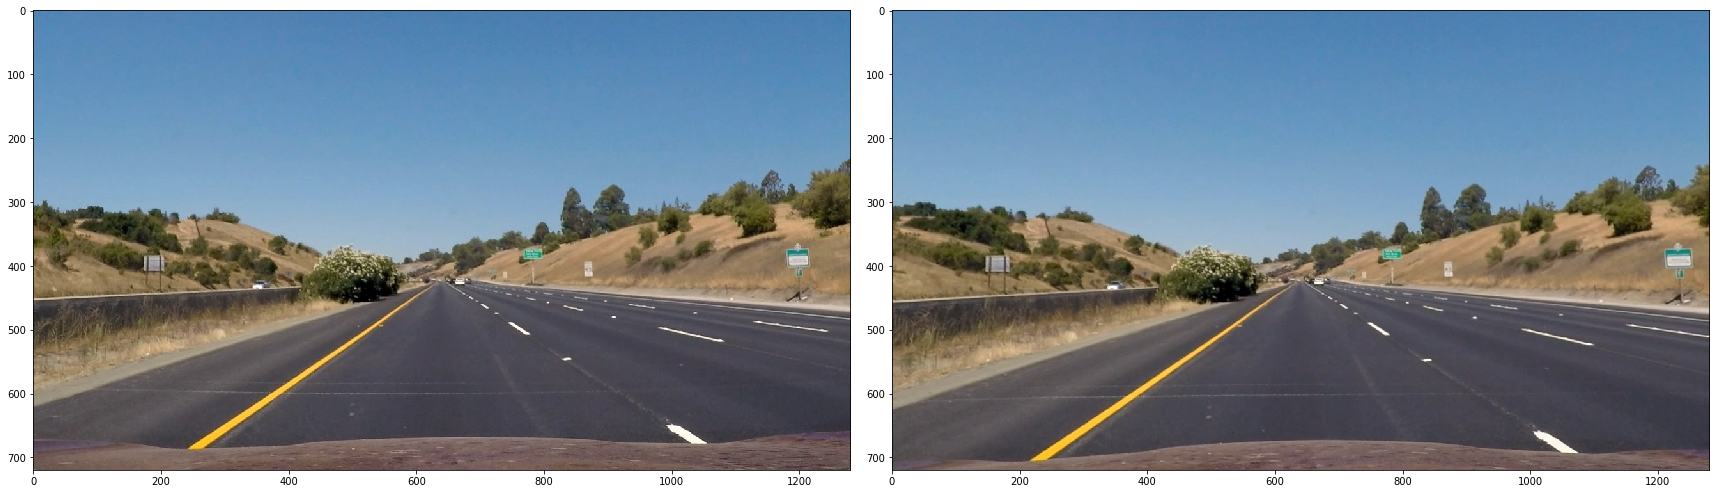

In [5]:
src_img = mpimg.imread('test_images/straight_lines1.jpg')

undist_img = undistort(src_img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(src_img)
ax2.imshow(undist_img)

#### Criteria: Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

A perspective transform requires a transformation matrix which can be computed by using the cv2.getPerspectiveTransform() function. This function takes 4 source points and 4 destination points as an input and outputs the transformation matrix. The choice of points is shown in the image below.
Since the lane lines on the road inside the region of interest represent a rectangle, the destination points are chosen to build a rectange as well. This choice leads to a bird's eye view after the perspective transform. 
In case of swapping source and image points before passing them to the cv2.getPerspectiveTransform() function, the output is a matrix for transforming from bird's eye view back to the original perspective.

The transform is performed with the cv2.warpPerspective() function, which takes the image and the transformation matrix as input and outputs the transformed ("warped") image.  
An example of a transformed image is shown below.

In [6]:
# define function for perspective transform matrix and inverse matrix
def get_warp_mat(src_pts, dst_pts):
    warp_mtx = cv2.getPerspectiveTransform(src_pts, dst_pts)
    warp_inv_mtx = cv2.getPerspectiveTransform(dst_pts, src_pts)
    return (warp_mtx, warp_inv_mtx)

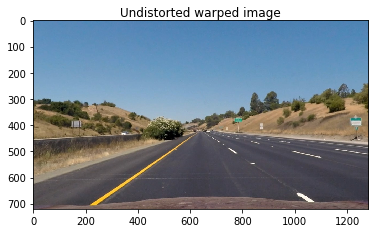

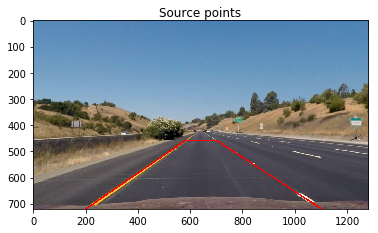

In [7]:
# define source and destination points for perspective transform

# read and undistort image
wrp_src_img = mpimg.imread('test_images/straight_lines1.jpg')
undist_wrp_img = cv2.undistort(wrp_src_img, mtx, dist_coeff)

# show undistorted image to determine source points
# %matplotlib notebook # enables zoom and mouse coordinates

show_img(undist_wrp_img, None, 'Undistorted warped image')
# plt.figure()
# plt.imshow(undist_wrp_img)
# plt.title('Undistorted image')

# source points manually determined from test image "straight_lines1.jpg"
src_pts = np.array([[580, 460], [700, 460], [1100, rows], [200, rows]], 
                   np.float32).reshape((4, 1, 2))
# src_pts = np.array([[560, 475], [725, 475], [1100, rows], [200, rows]], 
#                    np.float32).reshape((4, 1, 2))
# src_pts = np.array([[595, 450], [685, 450], [1100, rows], [200, rows]], 
#                    np.float32).reshape((4, 1, 2))

# destination points for perspective transformation
lane_dist = 700 # in pixels
mid_pnt = cols//2
dst_pts = np.array([[mid_pnt - lane_dist/2, 0], [mid_pnt + lane_dist/2, 0], 
                    [mid_pnt + lane_dist/2, rows], [mid_pnt - lane_dist/2, rows]], 
                   np.float32).reshape((4, 1, 2))

# show undistorted image with source area
undist_wrp_img_src = np.copy(undist_wrp_img)
draw_lines_from_points(undist_wrp_img_src, src_pts)
show_img(undist_wrp_img_src, None, 'Source points')

In [8]:
# compute perspective transform matrix and inverse matrix
warp_mtx, warp_inv_mtx = get_warp_mat(src_pts, dst_pts)
print('transformation matrix:\n', warp_mtx)
print('inverse transformation matrix:\n', warp_inv_mtx)

transformation matrix:
 [[ -5.55555556e-01  -1.50244200e+00   9.85726496e+02]
 [  0.00000000e+00  -1.97802198e+00   9.09890110e+02]
 [  2.93511629e-19  -2.38095238e-03   1.00000000e+00]]
inverse transformation matrix:
 [[  1.71428571e-01  -7.68518519e-01   5.30285714e+02]
 [  4.58932415e-17  -5.05555556e-01   4.60000000e+02]
 [  2.24588775e-19  -1.20370370e-03   1.00000000e+00]]


In [9]:
# define perspective transform function
def warp(img):
    warped_img = cv2.warpPerspective(img, warp_mtx, (cols, rows), flags=cv2.INTER_LINEAR)
    return warped_img

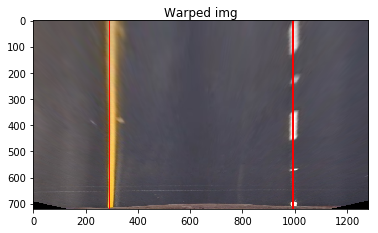

In [10]:
# perform perspective transformation
warped_img = cv2.warpPerspective(undist_wrp_img, warp_mtx, (cols, rows), flags=cv2.INTER_LINEAR)

# draw lines on warped image and plot
warped_img_roi = np.copy(warped_img)
draw_lines_from_points(warped_img_roi, dst_pts)
show_img(warped_img_roi, None, 'Warped img')

#### Criteria: Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image. Provide an example of a binary image result.

##### gradient (function sobel_thresh)

>"In our last example, output datatype is cv2.CV_8U or np.uint8. But there is a slight problem with that. Black-to-White transition is taken as Positive slope (it has a positive value) while White-to-Black transition is taken as a Negative slope (It has negative value). So when you convert data to np.uint8, all negative slopes are made zero. In simple words, you miss that edge.

>If you want to detect both edges, better option is to keep the output datatype to some higher forms, like cv2.CV_16S, cv2.CV_64F etc, take its absolute value and then convert back to cv2.CV_8U. Below code demonstrates this procedure for a horizontal Sobel filter and difference in results."

https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_gradients/py_gradients.html

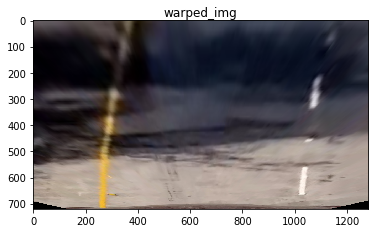

In [11]:
# read image and get size
# src_img = mpimg.imread('test_images/straight_lines1.jpg')
src_img = mpimg.imread('test_images/test5.jpg')

# undistort and warp
undist_img = undistort(src_img)
warped_img = warp(undist_img)

plt.imshow(warped_img)
plt.title('warped_img')

Grdient thresholds

In [12]:
# gradient thresholds

# define gradient threshold function
def grad_thresh(img, orient='x', 
                kernel = 3, thresh=(0, 255)):
    """Creates thresholded binary image based on directional 
    gradient"""
    # convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # take derivative in 'orient' direction
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel)
    else:
        print('only x and y are accepted as 2nd argument')
        return None
    # calculate absolute value and scale to 8-bit
    abs_sobel = np.abs(sobel)
    scaled_sobel = np.uint8(255 * abs_sobel/np.max(abs_sobel))
    # create binary image
    grad_bin = np.zeros_like(scaled_sobel)
    grad_bin[(scaled_sobel >= thresh[0]) & 
                (scaled_sobel <= thresh[1])] = 1
    # return binary image
    return grad_bin

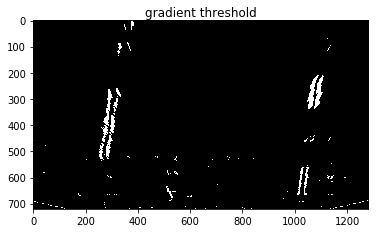

In [13]:
# create and plot gradient threshold image
bin_grad_img = grad_thresh(warped_img, 'x', 
                          kernel = 3, thresh = (20, 255))
plt.imshow(bin_grad_img, cmap = 'gray')
plt.title('gradient threshold')

In [14]:
# define gradient magnitude function
def grad_mag_thresh(img, kernel = 3, thresh = (0, 255)):
    # convert to grayscale    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # apply sobel in both x and y direction
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel)
    # calculate magnitude
    abs_sobelxy = np.sqrt(sobelx**2 + sobely**2)
    # scale to 8-bit and convert to type uint8
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    # create binary magnitude image
    grad_mag_bin = np.zeros_like(scaled_sobel)
    grad_mag_bin[(scaled_sobel >= thresh[0]) & 
            (scaled_sobel <= thresh[1])] = 1
    # return binary image
    return grad_mag_bin

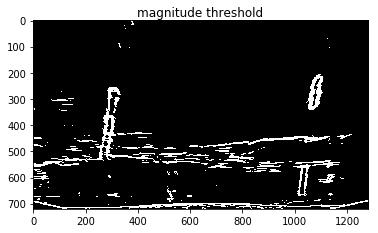

In [15]:
# create and plot gradient magnitude threshold image
bin_grad_mag_img = grad_mag_thresh(warped_img, kernel = 9, thresh = (20, 255))
plt.imshow(bin_grad_mag_img, cmap = 'gray')
plt.title('magnitude threshold')

In [16]:
# define gradient direction threshold function
def grad_dir_thresh(image, kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    
    # convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # apply sobel
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel)
    # calculate absolute values of sobelx and sobely
    abs_sobelx = np.abs(sobelx)
    abs_sobely = np.abs(sobely)
    # calculate gradient direction
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    # apply threshold
    grad_dir_bin = np.zeros_like(gray)
    grad_dir_bin[(grad_dir >= thresh[0]) & 
            (grad_dir <= thresh[1])] = 1
    
    return grad_dir_bin

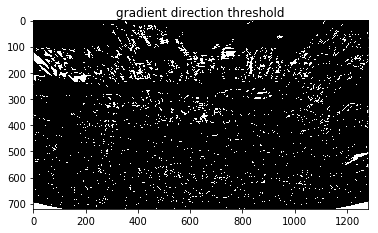

In [17]:
# create and plot gradient direction threshold image
grad_dir_bin_img = grad_dir_thresh(warped_img, 
                         kernel = 7, thresh = (0, 0.1))
plt.imshow(grad_dir_bin_img, cmap = 'gray')
plt.title('gradient direction threshold')

Color thresholds

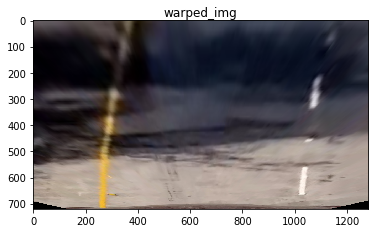

In [18]:
src_img = mpimg.imread('test_images/test5.jpg')

# undistort and warp
undist_img = undistort(src_img)
warped_img = warp(undist_img)

plt.imshow(warped_img)
plt.title('warped_img')

In [19]:
# color thresholds

def rgb_color_thresh(img, ch, thresh=(0, 255), show=False):
    if ch=='r':
        out = img[:,:,0] # r channel
    if ch=='g':
        out = img[:,:,1] # g channel
    if ch=='b':
        out = img[:,:,2] # b channel
        
    if show==True:
        show_img(out, 'gray', ch)

    # apply threshold
    rgb_col_bin = np.zeros_like(img[:,:,2])
    rgb_col_bin[(out > thresh[0]) & (out <= thresh[1])] = 1
    
    return rgb_col_bin
    

# define color threshold function
def hls_color_thresh(img, ch, thresh=(0, 255), show=False):
    # convert image to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    if ch=='h':
        out = hls[:,:,0] # h channel
    if ch=='l':
        out = hls[:,:,1] # l channel
    if ch=='s':
        out = hls[:,:,2] # s channel
        
    if show==True:
        show_img(out, 'gray', ch)

    # apply threshold
    hls_col_bin = np.zeros_like(hls[:,:,2])
    hls_col_bin[(out > thresh[0]) & (out <= thresh[1])] = 1
    return hls_col_bin

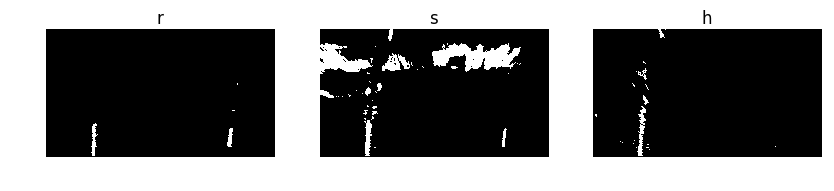

In [20]:
r_bin = rgb_color_thresh(warped_img, 'r', thresh = (220, 255), show=False)
s_bin = hls_color_thresh(warped_img, 's', thresh = (130, 255), show=False)
h_bin = hls_color_thresh(warped_img, 'h', thresh = (19, 50), show=False)

col_bin = (r_bin, s_bin, h_bin)
cmaps = (['gray']*3)
show_imgs(col_bin, cmaps, (['r','s','h']), 1,3)

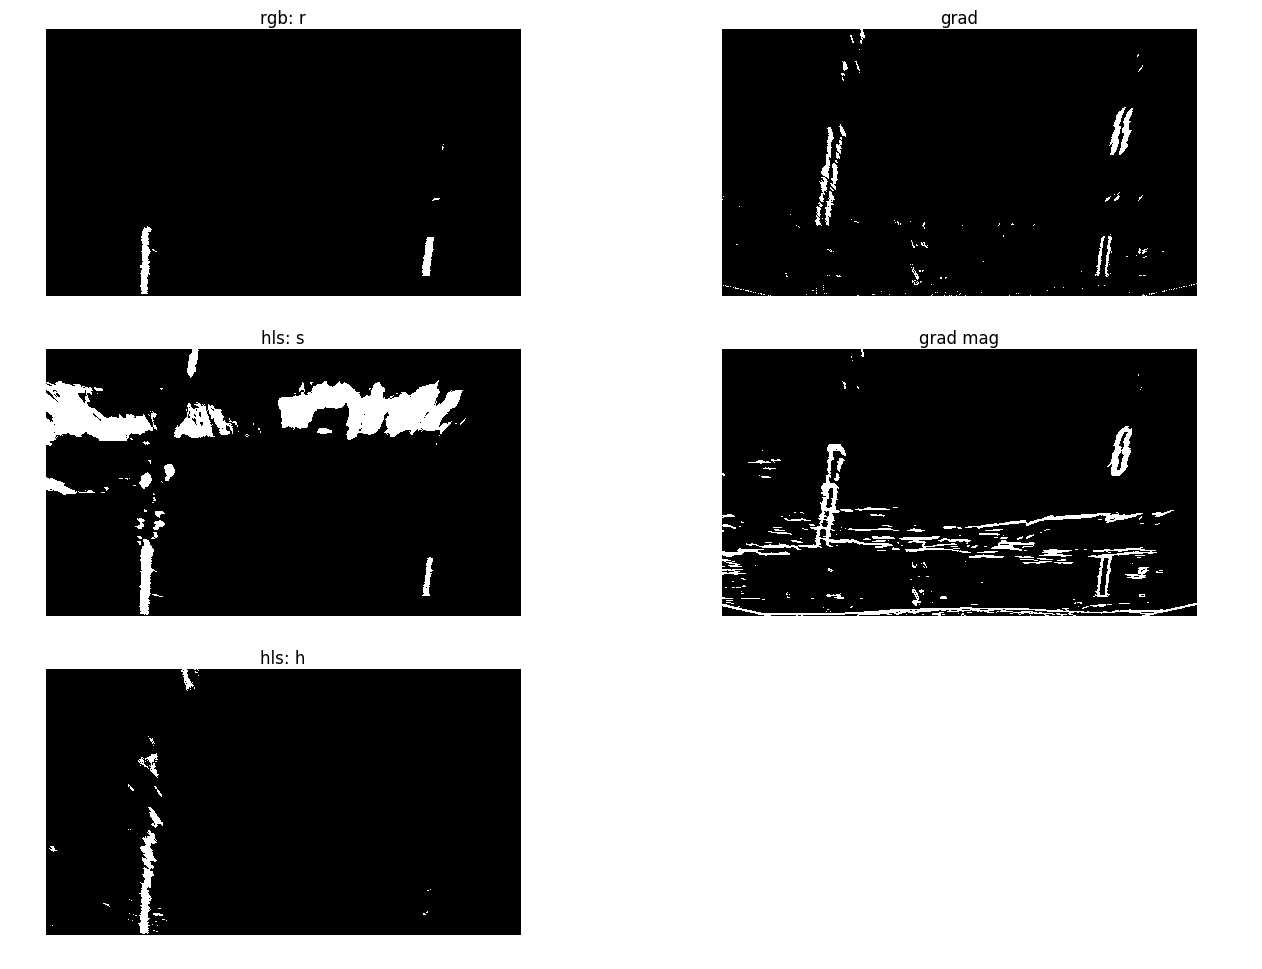

In [21]:
# create and plot combined threshold image

# color
r_bin = rgb_color_thresh(warped_img, 'r', thresh = (220, 255), show=False)
s_bin = hls_color_thresh(warped_img, 's', thresh = (130, 255), show=False)
h_bin = hls_color_thresh(warped_img, 'h', thresh = (19, 50), show=False)


# gradient
grad_bin = grad_thresh(warped_img, 'x', 3, [20,255])


grad_mag_bin = grad_mag_thresh(warped_img, 9, [20,255])

bin_imgs = (r_bin, grad_bin, s_bin, grad_mag_bin, h_bin)
cmaps = (['gray']*5)
show_imgs(bin_imgs, cmaps, ('rgb: r','grad','hls: s','grad mag','hls: h'), 3,2, 16,12)

In [22]:
def create_bin_img(warped_img):
    # color
    r_col_bin = rgb_color_thresh(warped_img, 'r', thresh = (220, 255), show=False)
    s_col_bin = hls_color_thresh(warped_img, 's', thresh = (130, 255), show=False)
    h_col_bin = hls_color_thresh(warped_img, 'h', thresh = (17, 50), show=False)
    # gradient
    grad_bin = grad_thresh(warped_img, 'x', 3, [20,255])

    bin_img = np.zeros_like(r_col_bin)
    bin_img[(r_col_bin==1) | ( (s_col_bin==1) & (h_col_bin==1) ) | grad_bin==1] = 1

#     show_img(bin_img, 'gray', 'combination')
    return bin_img

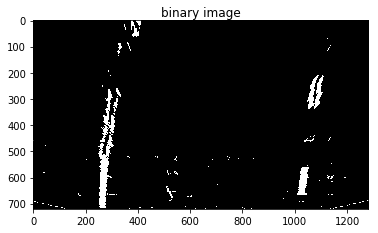

In [23]:
bin_img = create_bin_img(warped_img)
show_img(bin_img, 'gray', 'binary image')

#### Criteria: Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?



In [24]:
# functions called in find_lane_pixels() function


# functions called inside for loop
    
def draw_win(img, win_x, win_y):
    # draw windows on image
    cv2.rectangle(img, (win_x[0], win_y[0]), (win_x[1], win_y[1]), (0, 255, 0), 2)
    return None

In [25]:
# number of sliding windows
n_win = 9
# windows width (+/-margin)
margin = 100
# min number of pixels to recenter window
min_pix = 50
# set window height
win_h = np.int(img.shape[0]//n_win)

In [26]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self, histlen):
        # number of recent lines to be stored
        self.histlen = histlen
        # counter for failed line detections
        self.fail_count = histlen
        # indicator for failure: no useful detection even with sliding window search
        self.fail_flag = False
        #x values for detected line pixels
        self.x = None  
        #y values for detected line pixels
        self.y = None
        # x values of the current fit
        self.fit_x = None
        # y values of the current fit
        self.ploty = None
        # x values of the last n fits of the line
        self.list_fit_x = deque(maxlen=self.histlen) 
        #average x values of the fitted line over the last n iterations
        self.avg_fit_x = None    
        #polynomial coefficients averaged over the last n iterations
        self.avg_fit = deque(maxlen=self.histlen)
        #polynomial coefficients for the most recent fit
        self.fit = [np.array([False])]
        #radius of curvature of the line in some units
        self.curverad = None
        # curve radii of the last n fits
        self.list_curverad = deque(maxlen=self.histlen)
        # average of the last n radii
        self.avg_curverad = None
        # distance in meters of vehicle center from the line
        self.offset = None
        # list of offset values of the last n fits
        self.list_offset = deque(maxlen=self.histlen)
        # average offset of last fits
        self.avg_offset = None
        #difference in fit coefficients between last and new fits
#         self.diffs = np.array([0,0,0], dtype='float') 

In [27]:
def sliding_window(img, side, show_win=False):
    print('sliding windows, ', side)
        
    # create histogramm from bottom half of the image
    hist = np.sum(img[img.shape[0]//2:, :], axis = 0)
    # find midpoint
    mid_pnt = np.int(hist.shape[0]//2)
    # find left and right windows start positions based on peaks in histogram
    if side=='left':
        x_start = np.argmax(hist[:mid_pnt])
    if side=='right':
        x_start = np.argmax(hist[mid_pnt:]) + mid_pnt
    # if no line is detected
    if (x_start==0 | x_start== mid_pnt):
        x_start = -1
    
    # find x and y positions of all nonzero pixels
    nonzero_y = np.array(img.nonzero()[0])
    nonzero_x = np.array(img.nonzero()[1])
    
    # initialize current window positions with start values from histogram
    x_current = x_start
    
    # initialization of empty lists for lane pixel indices
    lane_inds = []

#     allwinx = np.array([],dtype=int)
#     allwiny = np.array([],dtype=int)
    
    # create 3 channel image
    out_img = np.dstack((img, img, img))*255
    
    # loop through all windows
    for win in range(n_win):
        
        # determine window y boundaries
        winy_low = img.shape[0] - (win + 1) * win_h
        winy_high = img.shape[0] - win * win_h -1
        winy = np.array([winy_low, winy_high])
        # determine window x boundaries
        winx_low = x_current - margin
        winx_high = x_current + margin
        winx = np.array([winx_low, winx_high])
        
        # find nonzero pixels in x and y within current window
        good_inds = ((nonzero_y >= winy[0]) & (nonzero_y < winy[1]) & 
                                  (nonzero_x >= winx[0]) & (nonzero_x < winx[1])).nonzero()[0]

        # append the indices to the lists
        lane_inds.append(good_inds)
        
        # if pixels in window > minpix pixels, recenter next window on their mean position
        if np.count_nonzero(good_inds) > min_pix:
            x_current = np.uint16(np.mean(nonzero_x[good_inds]))

#         allwinx = np.concatenate([allwinx, winx])
#         allwiny = np.concatenate([allwiny, winy])
        if show_win==True:
            # draw current window
            draw_win(out_img, winx, winy)
        
    try:
        # create one array of indices out of the list of lists
        lane_inds = np.concatenate(lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass
        
    # Extract left and right line pixel positions
    x = nonzero_x[lane_inds]
    y = nonzero_y[lane_inds] 
    
    ## Visualization ##
    # Colors in the left and right lane regions
    
    if side=='left':
        out_img[y, x] = [255, 0, 0]
    if side=='right':
        out_img[y, x] = [0, 0, 255]
    
    return (x, y, out_img)

sliding windows,  left


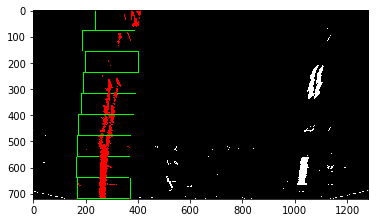

sliding windows,  right
(720, 1280, 3)


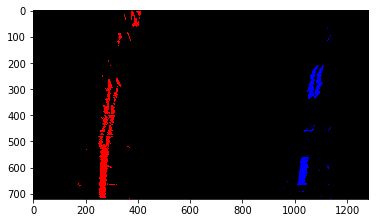

In [29]:
leftx, lefty, pix_img_left = sliding_window(bin_img, 'left', True)
show_img(pix_img_left)

rightx, righty, pix_img_right = sliding_window(bin_img, 'right', True)
# show_img(line_pix_img_right)

# line_pix_img = cv2.add(line_pix_img_left[:,:,0], line_pix_img_right[:,:,2])
# line_pix_img = np.maximum(line_pix_img_left, line_pix_img_right)
# show_img(line_pix_img)

out_img = np.zeros_like(undist_img)
print(out_img.shape)


red_inds = np.where((pix_img_left[:,:,0]==255) & (pix_img_left[:,:,2]==0))
blue_inds = np.where((pix_img_right[:,:,2]==255) & (pix_img_right[:,:,0]==0))

out_img[red_inds[0],red_inds[1],0] = 255
out_img[blue_inds[0],blue_inds[1],2] = 255

# out_img[:,:,blue_inds] = 255
show_img(out_img)
# # create 3 channel image
# out_img = np.zeros_like(undist_img)
# out_img[lefty,leftx]=[255,0,0]
# out_img[righty,rightx]=[0,0,255]
# show_img(out_img)

In [30]:
def fit_poly(img, side, x, y, show=False):
    print('fit poly, ', side)
            
    # Fit a second order polynomial to each using `np.polyfit`
#     if (x==[] or y==[]):
#         import pdb; pdb.set_trace()
    fit = np.polyfit(y, x, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0], dtype=int)
    try:
        fitx = (fit[0]*ploty**2 + fit[1]*ploty + fit[2]).astype(int)
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        fitx = np.ones_like(ploty)
        if side=='left':
            fitx = cols//4
        if side=='right':
            fitx = cols-cols//4
        l_line.detected = False
        r_line.detected = False
#         fitx = (1*ploty**2 + 1*ploty).astype(ing)
    
    # limit values that are out of bounds
    fitx[fitx<0]=0
    fitx[fitx>cols-1]=cols-1
    
#     lane_fit_img = np.dstack((lane_pix_img, lane_pix_img, lane_pix_img))*255
    
    lane_fit_img = np.dstack((img, img, img))*255
    lane_fit_img[ploty, fitx] = [255,255,0]
#     Plots the left and right polynomials on the lane lines
    if show==True:
        
        plt.plot(fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')

    return (fit, ploty, fitx, lane_fit_img)


In [31]:
histlen = 3
l_line = Line(histlen)
r_line = Line(histlen)

In [32]:
def draw_poly(img, left_fitx, right_fitx, ploty):
    
    left_pts = np.vstack([left_fitx, ploty]).T
    right_pts = np.vstack([right_fitx, ploty]).T

    cv2.polylines(img, ([left_pts]), False, [255,0,0],thickness=10)
    cv2.polylines(img, ([right_pts]), False, [0,0,255],thickness=10)
    
    return img

fit poly,  left
fit poly,  right


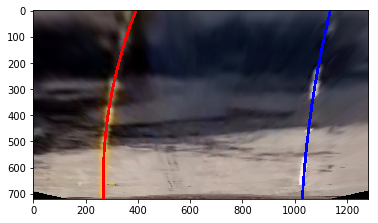

In [33]:
left_fit, ploty, left_fitx, lane_fit_img_left = fit_poly(bin_img, 'left', leftx, lefty, show=False)
right_fit, ploty, right_fitx, lane_fit_img_right = fit_poly(bin_img, 'right', rightx, righty, show=False)

poly_img = draw_poly(warped_img, left_fitx, right_fitx, ploty)

show_img(poly_img)

# fit_img_add = cv2.add(lane_fit_img_left, lane_fit_img_right)
# show_img(fit_img_add, 'gray', 'add')

# fit_img = cv2.addWeighted(lane_fit_img_left,1,lane_fit_img_right,1,0)
# show_img(fit_img, 'gray', 'addWeighted')

In [34]:
def proximity_search(img, side, line_obj):
    print('proximity search, ', side)
    
    nonzero_y = np.array(img.nonzero()[0])
    nonzero_x = np.array(img.nonzero()[1])
    
#     if side=='left':
    lane_inds = ((nonzero_x > 
                (line_obj.avg_fit[0]*(nonzero_y**2) + line_obj.avg_fit[1]*nonzero_y + 
                 line_obj.avg_fit[2] - margin)) 
                & (nonzero_x < 
                (line_obj.avg_fit[0]*(nonzero_y**2) + line_obj.avg_fit[1]*nonzero_y + 
                 line_obj.avg_fit[2] + margin)))
#     if side=='right':
#         lane_inds = ((nonzero_x > 
#                     (r_line.fit[0]*(nonzero_y**2) + r_line.fit[1]*nonzero_y + 
#                      r_line.fit[2] - margin)) 
#                     & (nonzero_x < 
#                     (r_line.fit[0]*(nonzero_y**2) + r_line.fit[1]*nonzero_y + 
#                      r_line.fit[2] + margin)))
    
    x = nonzero_x[lane_inds]
    y = nonzero_y[lane_inds] 
    
    ## Visualization ##
    # Colors in the left and right lane regions
    out_img = np.dstack((img, img, img))*255
    if side=='left':
        out_img[y, x] = [255, 0, 0]
    if side=='right':
        out_img[y, x] = [0, 0, 255]
    
#     if show==True:
#         src_img = np.copy(img)
#         lane_img = np.zeros_like(src_img)
#         lane_img[left_y, left_x] = [255, 0, 0]
#         lane_img[right_y, right_y] = [0, 0, 255]
#         cv2.addWeighted(src_img, 1, lane_img, 1, 0)
    
    return (x, y, out_img)

In [35]:
# conversion from pixel space to meters
ym_per_pix = 21/720
xm_per_pix = 3.7/900

#### Criteria: Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

$R_{curve} = \frac{(1 + (2 Ay + B)²)^{3/2}}{\lvert2A\rvert}$

In [36]:
def curve_radius(x_vals, y_vals):
    
    real_fit = np.polyfit(y_vals*ym_per_pix, x_vals*xm_per_pix, 2)
    
    num = (1 + (2*real_fit[0]*np.max(y_vals)*ym_per_pix + real_fit[1])**2)**(3/2)
    denum = np.abs(2*real_fit[0])
    radius = num/denum
    
    return radius

def get_offset(left_fitx, right_fitx):
    # check if values for both lines exist
    if (left_fitx==[] or right_fitx==[]):
        return np.nan #-999
    else:
        lane_mid = np.mean([left_fitx[-1], right_fitx[-1]])
        center = cols//2
        # negative value means car is left from center
        offset = (center - lane_mid)*xm_per_pix
        
        return offset

In [37]:
left_radius = curve_radius(left_fitx, ploty)
right_radius = curve_radius(right_fitx, ploty)
radius = np.mean([left_radius, right_radius])
print(radius)

offset = get_offset(left_fitx, right_fitx)
print(offset)

570.590037081
-0.0287777777778


#### Criteria: Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

# show plot lane function

In [38]:
histlen=3
l_line=Line(histlen)
r_line=Line(histlen)

In [39]:

def plot_lane(left_fitx, right_fitx, ploty, undist_img):
    
    # check if detection of valid lines has failed
    if l_line.fail_flag==True:
        return undist_img
    else:
        warped_lane_img = np.zeros_like(undist_img)

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        l_array = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        r_array = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        line_pts = np.hstack((l_array, r_array))


        
        # Draw the lane onto the warped blank image
        cv2.fillPoly(warped_lane_img, np.int_([line_pts]), (0,255,0))

#         import pdb; pdb.set_trace()        
        left_pts = np.reshape(l_array,(-1,2))
        right_pts = np.reshape(r_array,(-1,2))
        cv2.polylines(warped_lane_img, ([left_pts]), False, [255,0,0], thickness=20)
        cv2.polylines(warped_lane_img, ([right_pts]), False, [0,0,255], thickness=20)
        

#         left_pts = np.vstack([left_fitx, ploty]).T
#         right_pts = np.vstack([right_fitx, ploty]).T

#         cv2.polylines(img, ([left_pts]), False, [255,0,0],thickness=10)
#         cv2.polylines(img, ([right_pts]), False, [0,0,255],thickness=10)
    
        
        unwarped_lane_img = cv2.warpPerspective(warped_lane_img, warp_inv_mtx, (cols, rows), flags = cv2.INTER_LINEAR)

        weighted_img = cv2.addWeighted(undist_img, 1, unwarped_lane_img, 0.3, 0)
    
    return weighted_img

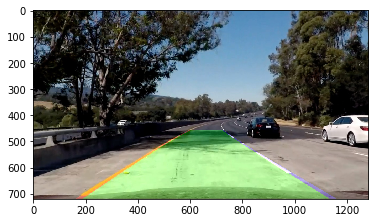

In [40]:
overlay_img = plot_lane(left_fitx, right_fitx, ploty, undist_img)
plt.imshow(overlay_img)

test plot_txt function

In [41]:
def plot_txt(img):
        
    font_face = cv2.FONT_HERSHEY_SIMPLEX
    font_size = 1.5
    thickness = 3
    
    # check if detection of valid lines has failed
    if l_line.fail_flag==True:
        cv2.putText(img, 'left radius: {:.2f}m, right radius: {:.2f}m, distance: {:.2f}m'.format(l_line.curverad,r_line.curverad,line_dist()), (100,140), font_face, 
                    font_size, (255,0,0), thickness)
        
    else:
        pos_rad = (100, 100)
        pos_off = (100, 180)
#         import pdb; pdb.set_trace()
        radius = np.mean([l_line.avg_curverad, r_line.avg_curverad])
        cv2.putText(img, 'curvature radius: {:.2f}m'.format(radius), pos_rad, font_face, 
                    font_size, (255,255,255), thickness)
        
        # calculate distance of vehicle from lane center
#         l_line.offset = get_offset(l_line.avg_fit_x, r_line.avg_fit_x)
        
        if offset<0:
            cv2.putText(img, 'Vehicle pos: {:.2f}m left from center'.format(l_line.avg_offset), pos_off, font_face, 
                        font_size, (255,255,255), thickness)
        else:
            cv2.putText(img, 'Vehicle pos: {:.2f}m right from center'.format(l_line.avg_offset), pos_off, font_face, 
                        font_size, (255,255,255), thickness)

            
            
def plot_txt2(img, lfit, rfit):
    if l_line.fail_flag==False:
        font_face = cv2.FONT_HERSHEY_SIMPLEX
        font_size = 1
        thickness = 3
        pos = (100, 260)
        cv2.putText(img, 'left: {:.2f}µ y^2+{:.2f}y+{:.2f}, right: {:.2f}µ y^2+{:.2f}y+{:.2f}'.format(lfit[0]*1e6,lfit[1],lfit[2],rfit[0]*1e6,rfit[1],rfit[2]), pos, font_face, 
                    font_size, (255,255,255), thickness)

In [42]:
# plot_txt(overlay_img)
# plt.imshow(overlay_img)

In [43]:
def line_dist():
     # calculate line distane
    bottom_dist = (r_line.fit_x[rows-1] - l_line.fit_x[rows-1])*xm_per_pix
    middle_dist = (r_line.fit_x[rows//2] - l_line.fit_x[rows//2])*xm_per_pix
    top_dist = (r_line.fit_x[0] - l_line.fit_x[0])*xm_per_pix
    return np.mean([bottom_dist, middle_dist, top_dist])

In [44]:
def sanity_check(line_obj):
    print('sanity check')
    
    # check if left and right lines have similar curvature and line distance is plausible (approx 3.7m)
    if (np.abs(l_line.curverad - r_line.curverad) < 1100) & (abs(line_dist() - 3.7) < 1):
        print('sanity check passed')
        return True
        
    else: # sanity check failed
        print('sanity check failed')
        print('left_rad: ', l_line.curverad, ', right_rad:', r_line.curverad, ', distance: ', line_dist())
        return False

In [45]:
def update_line(res, line_obj):
    # if sanity check passed
    if res==True:
        # update line object
        line_obj.fail_count = 0
        line_obj.fail_flag = False
        line_obj.list_fit_x.append(line_obj.fit_x)
        line_obj.avg_fit_x = np.mean(line_obj.list_fit_x, axis=0).astype(int)
        line_obj.avg_fit = np.polyfit(line_obj.ploty, line_obj.avg_fit_x, 2)
        line_obj.list_curverad.append(line_obj.curverad)
        line_obj.avg_curverad = np.mean(line_obj.list_curverad, axis=0)
        line_obj.list_offset.append(line_obj.offset)
        line_obj.avg_offset = np.mean(line_obj.list_offset)
    # if sanity check failedr
    else:
        # if maximum number of fail counts is not exceeded, increment counter and add existing mean
        # values to all deques
        if line_obj.fail_count < line_obj.histlen:
            line_obj.fail_count += 1
            line_obj.fail_flag = False
            # append existing mean to deques to not change the new mean value
#             line_obj.list_fit_x.append(line_obj.avg_fit_x)
#             line_obj.list_curverad.append(line_obj.avg_curverad)
#             line_obj.list_offset.append(line_obj.avg_offset)
        # if maximum number of fail counts is exceeded, reset instance variables
        if line_obj.fail_count >= line_obj.histlen:
            line_obj.fail_flag = True
            line_obj.list_fit_x = deque(maxlen=line_obj.histlen)
            line_obj.avg_fit_x = None    
            line_obj.avg_fit = deque(maxlen=line_obj.histlen)
            line_obj.list_curverad = deque(maxlen=line_obj.histlen)
            line_obj.avg_curverad = None
            line_obj.list_offset = deque(maxlen=line_obj.histlen)
            line_obj.avg_offset = None

In [46]:
def find_line_pix(bin_img, side, line_obj):
    
    # perform sliding window search when fail counter is exceeded
    if line_obj.fail_count>=line_obj.histlen:
        x, y, line_pix_img = sliding_window(bin_img, side)
    else:
        x, y, line_pix_img = proximity_search(bin_img, side, line_obj)
    
    return x, y, line_pix_img

In [47]:
def pipeline(src_img):
    
    undist_img = undistort(src_img)
    
    warped_img = warp(undist_img)
    
    bin_img = create_bin_img(warped_img)
    
    l_line.x, l_line.y, line_pix_img_left = find_line_pix(bin_img, 'left', l_line)
    r_line.x, r_line.y, line_pix_img_right = find_line_pix(bin_img, 'right', r_line)
    
    l_line.fit, l_line.ploty, l_line.fit_x, line_fit_img_left = fit_poly(bin_img, 'left', l_line.x, l_line.y)
    r_line.fit, r_line.ploty, r_line.fit_x, line_fit_img_right = fit_poly(bin_img, 'right', r_line.x, r_line.y)

    l_line.curverad = curve_radius(l_line.x, l_line.y)
    r_line.curverad = curve_radius(r_line.x, r_line.y)
    l_line.offset = get_offset(l_line.fit_x, r_line.fit_x) # offset identical for both lines
    r_line.offset = get_offset(l_line.fit_x, r_line.fit_x) # offset identical for both lines
    
    res = sanity_check(l_line)
    
    update_line(res, l_line)
    update_line(res, r_line)
    
    
    lane_img = plot_lane(l_line.avg_fit_x, r_line.avg_fit_x, l_line.ploty, undist_img)
    plot_txt(lane_img)
    
    plot_txt2(lane_img, l_line.avg_fit, r_line.avg_fit)
    
    comb_img = create_comb_img(lane_img, warped_img, line_pix_img_left, line_pix_img_right, line_fit_img_left, line_fit_img_right)
    
    return comb_img
#     return lane_area_img
#     return np.dstack((bin_img, bin_img, bin_img))*255 

In [48]:
# line object instantiation
histlen=7
l_line = Line(histlen)
r_line = Line(histlen)

sliding windows,  left
sliding windows,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed


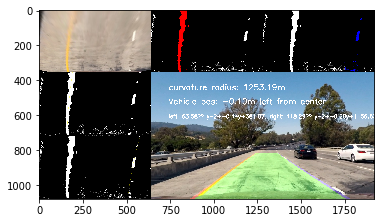

In [49]:
# read image and get size
# src_img = mpimg.imread('test_images/straight_lines1.jpg')
src_img = mpimg.imread('test_images/test1.jpg')

dst_img = pipeline(src_img)
show_img(dst_img)

In [50]:
white_output = 'output_videos/project_video.mp4'
clip1 = VideoFileClip("project_video.mp4").subclip(35,42)
# clip1 = VideoFileClip("project_video.mp4").subclip(38,40)
# clip1 = VideoFileClip('project_video.mp4')
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   0%|          | 0/175 [00:00<?, ?it/s, now=None]

proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
Moviepy - Building video output_videos/project_video.mp4.
Moviepy - Writing video output_videos/project_video.mp4

proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right


t:   2%|▏         | 3/175 [00:00<00:14, 11.74it/s, now=None]

sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed


t:   3%|▎         | 5/175 [00:00<00:14, 11.62it/s, now=None]

proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right


t:   4%|▍         | 7/175 [00:00<00:14, 11.86it/s, now=None]

sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check failed
left_rad:  547.218503309 , right_rad: 2138.14122204 , distance:  3.12992592593


t:   5%|▌         | 9/175 [00:00<00:14, 11.84it/s, now=None]

proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check failed
left_rad:  534.582004386 , right_rad: 2928.59124282 , distance:  3.10525925926
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed


t:   7%|▋         | 13/175 [00:01<00:13, 11.96it/s, now=None]

proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed


t:   9%|▊         | 15/175 [00:01<00:13, 12.10it/s, now=None]

proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed


t:  11%|█         | 19/175 [00:01<00:12, 12.26it/s, now=None]

proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check failed
left_rad:  1755.40392549 , right_rad: 618.302147214 , distance:  3.08744444444
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed


t:  12%|█▏        | 21/175 [00:01<00:12, 12.28it/s, now=None]

proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed


t:  14%|█▍        | 25/175 [00:02<00:12, 12.45it/s, now=None]

proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check failed
left_rad:  1031.63037843 , right_rad: 2482.34049213 , distance:  3.01481481481
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed


t:  17%|█▋        | 29/175 [00:02<00:11, 12.55it/s, now=None]

proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed


t:  18%|█▊        | 31/175 [00:02<00:11, 12.46it/s, now=None]

proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left


t:  19%|█▉        | 33/175 [00:02<00:11, 12.07it/s, now=None]

fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed


t:  20%|██        | 35/175 [00:02<00:11, 12.17it/s, now=None]

proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed


t:  22%|██▏       | 39/175 [00:03<00:11, 12.35it/s, now=None]

proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed


t:  25%|██▍       | 43/175 [00:03<00:10, 12.60it/s, now=None]

proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed


t:  26%|██▌       | 45/175 [00:03<00:10, 12.30it/s, now=None]

proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left


t:  27%|██▋       | 47/175 [00:03<00:10, 11.82it/s, now=None]

fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed


t:  28%|██▊       | 49/175 [00:04<00:10, 11.81it/s, now=None]

proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right


t:  30%|███       | 53/175 [00:04<00:10, 11.82it/s, now=None]

sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right


t:  31%|███▏      | 55/175 [00:04<00:10, 11.72it/s, now=None]

sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed


t:  33%|███▎      | 57/175 [00:04<00:10, 11.45it/s, now=None]

proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left


t:  34%|███▎      | 59/175 [00:04<00:10, 11.10it/s, now=None]

proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed


t:  36%|███▌      | 63/175 [00:05<00:10, 11.10it/s, now=None]

proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left


t:  37%|███▋      | 65/175 [00:05<00:10, 10.64it/s, now=None]

proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left


t:  38%|███▊      | 67/175 [00:05<00:10, 10.15it/s, now=None]

proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed


t:  39%|███▉      | 69/175 [00:05<00:10,  9.77it/s, now=None]

proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed


t:  41%|████      | 71/175 [00:06<00:11,  8.96it/s, now=None]

proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed


t:  42%|████▏     | 73/175 [00:06<00:10,  9.38it/s, now=None]

proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left


t:  43%|████▎     | 75/175 [00:06<00:10,  9.54it/s, now=None]

proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right


t:  44%|████▍     | 77/175 [00:06<00:10,  9.71it/s, now=None]

fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left


t:  45%|████▌     | 79/175 [00:06<00:10,  9.60it/s, now=None]

fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right


t:  46%|████▋     | 81/175 [00:07<00:09,  9.66it/s, now=None]

fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left


t:  47%|████▋     | 82/175 [00:07<00:09,  9.40it/s, now=None]

proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left


t:  48%|████▊     | 84/175 [00:07<00:09,  9.77it/s, now=None]

fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed


t:  50%|█████     | 88/175 [00:07<00:08,  9.87it/s, now=None]

proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed


t:  51%|█████▏    | 90/175 [00:08<00:08,  9.71it/s, now=None]

proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed


t:  53%|█████▎    | 92/175 [00:08<00:08,  9.93it/s, now=None]

proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed


t:  54%|█████▎    | 94/175 [00:08<00:08,  9.50it/s, now=None]

proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed


t:  55%|█████▍    | 96/175 [00:08<00:08,  9.68it/s, now=None]

proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left


t:  56%|█████▌    | 98/175 [00:08<00:07,  9.86it/s, now=None]

proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check failed
left_rad:  1715.91416187 , right_rad: 521.455354741 , distance:  2.99288888889
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check failed
left_rad:  10898.6113468 , right_rad: 558.159732975 , distance:  3.01344444444
proximity search,  left
proximity search,  right


t:  57%|█████▋    | 100/175 [00:09<00:07,  9.73it/s, now=None]

fit poly,  left
fit poly,  right
sanity check
sanity check failed
left_rad:  7891.31833101 , right_rad: 582.81058107 , distance:  2.98740740741
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check failed
left_rad:  8381.71693327 , right_rad: 873.63990634 , distance:  2.99288888889
proximity search,  left
proximity search,  right


t:  58%|█████▊    | 101/175 [00:09<00:07,  9.73it/s, now=None]

fit poly,  left
fit poly,  right
sanity check
sanity check failed
left_rad:  4471.97584744 , right_rad: 864.542585974 , distance:  2.97507407407
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left


t:  59%|█████▉    | 104/175 [00:09<00:07,  9.66it/s, now=None]

fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left


t:  61%|██████    | 106/175 [00:09<00:06, 10.07it/s, now=None]

fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed


t:  62%|██████▏   | 108/175 [00:09<00:06, 10.22it/s, now=None]

proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check failed
left_rad:  1550.42894599 , right_rad: 438.971853749 , distance:  2.95725925926
proximity search,  left


t:  63%|██████▎   | 110/175 [00:10<00:06,  9.97it/s, now=None]

proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed


t:  65%|██████▍   | 113/175 [00:10<00:06,  9.72it/s, now=None]

proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed


t:  65%|██████▌   | 114/175 [00:10<00:06,  9.71it/s, now=None]

proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left


t:  67%|██████▋   | 117/175 [00:10<00:05,  9.68it/s, now=None]

proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left


t:  68%|██████▊   | 119/175 [00:11<00:06,  9.03it/s, now=None]

proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed


t:  69%|██████▉   | 121/175 [00:11<00:05,  9.12it/s, now=None]

proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed


t:  70%|███████   | 123/175 [00:11<00:05,  9.02it/s, now=None]

proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed


t:  71%|███████▏  | 125/175 [00:11<00:05,  9.59it/s, now=None]

proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left


t:  73%|███████▎  | 127/175 [00:11<00:05,  9.04it/s, now=None]

proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check failed
left_rad:  7236.49655147 , right_rad: 436.524735032 , distance:  3.16966666667


t:  74%|███████▎  | 129/175 [00:12<00:05,  8.96it/s, now=None]

proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check failed
left_rad:  1595.56930358 , right_rad: 416.34022297 , distance:  3.28066666667
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check failed
left_rad:  2324.18167365 , right_rad: 609.645928591 , distance:  3.35740740741


t:  75%|███████▍  | 131/175 [00:12<00:04,  9.23it/s, now=None]

proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left


t:  76%|███████▌  | 133/175 [00:12<00:04,  9.72it/s, now=None]

proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check failed
left_rad:  98441.5064824 , right_rad: 312.064826299 , distance:  3.22311111111
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check failed
left_rad:  1772.73924606 , right_rad: 552.216391199 , distance:  3.23818518519
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right


t:  77%|███████▋  | 135/175 [00:12<00:04,  9.63it/s, now=None]

sanity check
sanity check failed
left_rad:  2861.50709162 , right_rad: 219.953842865 , distance:  3.14911111111
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check failed
left_rad:  1508.52003005 , right_rad: 233.405260787 , distance:  3.16144444444
proximity search,  left
proximity search,  right


t:  78%|███████▊  | 137/175 [00:12<00:03,  9.85it/s, now=None]

fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left


t:  79%|███████▉  | 138/175 [00:13<00:03,  9.68it/s, now=None]

fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check failed
left_rad:  1933.92735891 , right_rad: 278.470273966 , distance:  3.33685185185


t:  81%|████████  | 142/175 [00:13<00:03,  9.98it/s, now=None]

proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left


t:  82%|████████▏ | 144/175 [00:13<00:02, 10.45it/s, now=None]

proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed


t:  83%|████████▎ | 146/175 [00:13<00:02, 10.37it/s, now=None]

proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left


t:  85%|████████▍ | 148/175 [00:13<00:02, 10.24it/s, now=None]

proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right


t:  86%|████████▌ | 150/175 [00:14<00:02, 10.30it/s, now=None]

fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check failed
left_rad:  1827.49170329 , right_rad: 478.749781832 , distance:  3.41633333333
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed


t:  88%|████████▊ | 154/175 [00:14<00:01, 10.51it/s, now=None]

proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right


t:  89%|████████▉ | 156/175 [00:14<00:01, 10.51it/s, now=None]

fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed


t:  90%|█████████ | 158/175 [00:14<00:01, 10.71it/s, now=None]

proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left


t:  91%|█████████▏| 160/175 [00:15<00:01, 10.43it/s, now=None]

proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right


t:  93%|█████████▎| 162/175 [00:15<00:01, 10.45it/s, now=None]

fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right


t:  94%|█████████▎| 164/175 [00:15<00:01, 10.05it/s, now=None]

fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right


t:  95%|█████████▍| 166/175 [00:15<00:00, 10.12it/s, now=None]

sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed


t:  97%|█████████▋| 170/175 [00:16<00:00,  9.83it/s, now=None]

proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left


t:  98%|█████████▊| 172/175 [00:16<00:00, 10.15it/s, now=None]

proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right


t:  99%|█████████▉| 174/175 [00:16<00:00, 10.11it/s, now=None]

fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left


fit poly,  right
sanity check
sanity check passed
proximity search,  left
proximity search,  right
fit poly,  left
fit poly,  right
sanity check
sanity check passed
Moviepy - Done !
Moviepy - video ready output_videos/project_video.mp4
CPU times: user 38.1 s, sys: 1 s, total: 39.1 s
Wall time: 18.5 s


In [51]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

# backup

In [ ]:
# ### todo: class and functions descriptions
# class Calibration:
    
#     def __init__(self, cam_mtx, dist_coeff, src_pts, dst_pts):
#         self.cam_mtx = cam_mtx
#         self.dist_coeff = dist_coeff
#         self.src_pts = src_pts
#         selfdd.dst_pts = dst_pts
#         self.warp_mtx = cv2.get_PerspectiveTransform(scr_pts, dst_pts)
        
#     def undistort(self, dist_img):
#         undist_img = cv2.undistort(dist_img, self.cam_mtx, 
#                                    self.dist_coeff, None, 
#                                    self.cam_mtx)
#         return undist_img
    
#     def warp(self, img):
#         warped_img = cv2.warpPerspective(img, self.warp_mtx, 
#                                          img_size, 
#                                          flags = cv2.INTER_LINEAR)
#         return warped_img

In [ ]:
# # unwarped_img = np.copy(undist_img)
# raw_img = mpimg.imread('test_images/test6.jpg')
# undist_img = calib.undistort(raw_img)
# # raw_img = mpimg.imread('test_images/test1.jpg')
# # undist_img = calib.undistort(raw_img)

# warp_mtx = cv2.getPerspectiveTransform(src_pts, dst_pts)
# warped_img = cv2.warpPerspective(undist_img, warp_mtx, 
#                                  (cols, rows), flags=cv2.INTER_LINEAR)

# plt.figure()
# plt.imshow(undist_img)
# line_img1 = draw_lines_from_points(undist_img, src_pts)
# plt.figure()
# plt.imshow(undist_img)

# plt.figure()
# plt.imshow(warped_img)
# line_img2 = draw_lines_from_points(warped_img, dst_pts)
# plt.figure()
# plt.imshow(warped_img)


In [ ]:
# # create black image to visualize detected pixels, windows and lane lines
# # def show_detected_lane_pixels(left_x, left_y, right_x, right_y, (cols, rows)):
# def show_detected_lane_pixels(left_x, left_y, right_x, right_y):
#     blk_img = np.zeros_like(bin_img)
# #     blk_img = np.zeros((cols, rows))
#     lane_img_bird = np.dstack((blk_img, blk_img, blk_img))
#     lane_img_bird[left_y, left_x] = [255, 0, 0]
#     lane_img_bird[right_y, right_x] = [0, 0, 255]
# #     plt.imshow(lane_img_bird)
#     return lane_img_bird

# def plot_lanes_on_image(left_x, left_y, right_x, right_y, undist_img):
#     lane_img_bird = show_detected_lane_pixels(left_x, left_y, right_x, right_y)
#     unwarped_lane_img = cv2.warpPerspective(lane_img_bird, warp_inv_mtx, (cols, rows), flags = cv2.INTER_LINEAR)
#     plt.figure(); plt.imshow(unwarped_lane_img)
#     weighted_img = cv2.addWeighted(undist_img, 1, unwarped_lane_img, 1, 0)
#     weighted_img = cv2.add(undist_img, unwarped_lane_img)
#     plt.figure(); plt.imshow(weighted_img)
#     return 

# weighted_img = plot_lanes_on_image(leftx, lefty, rightx, righty, undist_img)
# # plt.imshow(weighted_img)

# undist_img_cp = np.copy(undist_img)